In [36]:
# Imports and variables
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import sklearn.metrics
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from config import Config
import utils
import model as modellib
import visualize
from model import log

from idrid import IdridConfig, IdridDataset


# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
MODEL_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_idrid.h5")

In [2]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [3]:
# Load testing dataset
dataset_test = IdridDataset()
dataset_test.load_idrid('test')
dataset_test.prepare()

  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
100%|██████████| 6/6 [00:44<00:00,  7.43s/it]


In [4]:
# Config
class TestConfig(IdridConfig):
    IMAGES_PER_GPU = 1
    
config = TestConfig()

In [19]:
# Load model and weights
model = modellib.MaskRCNN(mode="inference", config=config,
                          model_dir=MODEL_DIR)
model.load_weights('/home/chuqh/Documents/idrid-2/logs/idrid20180402T1718/mask_rcnn_idrid_0146.h5', by_name=True)

# Test on Random Image

original_image           shape: (384, 384, 3)         min:    0.00000  max:  255.00000
image_meta               shape: (14,)                 min:    0.00000  max:  384.00000
gt_class_id              shape: (249,)                min:    1.00000  max:    5.00000
gt_bbox                  shape: (249, 4)              min:   33.00000  max:  356.00000
gt_mask                  shape: (384, 384, 249)       min:    0.00000  max:    1.00000


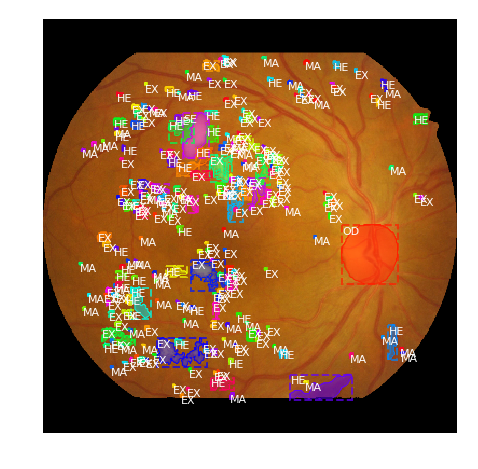

In [31]:
# See ground truth
image_id = random.choice(dataset_test.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_test, config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_test.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (384, 384, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 384, 384, 3)      min: -123.70000  max:  131.30000
image_metas              shape: (1, 14)               min:    0.00000  max:  384.00000


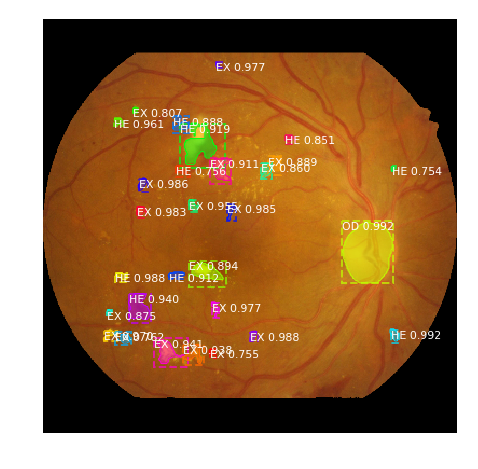

In [32]:
# See model inference
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_test.class_names, r['scores'], ax=get_ax())

In [24]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = dataset_test.image_ids
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_test, config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.05752718502899979


In [42]:
print(recalls)
print(precisions)

[0.         0.00337838 0.00337838 0.00675676 0.00675676 0.00675676
 0.01013513 0.01351351 0.01351351 0.01689189 0.02027027 0.02027027
 0.02027027 0.02027027 0.02027027 0.02027027 0.02027027 0.02027027
 0.02364865 0.02364865 0.02364865 0.02364865 0.02364865 0.02364865
 0.02364865 0.02702703 0.02702703 0.02702703 0.02702703 1.        ]
[1.         1.         0.66666667 0.66666667 0.6        0.6
 0.6        0.6        0.6        0.6        0.6        0.54545455
 0.5        0.46153846 0.42857143 0.4        0.38888889 0.38888889
 0.38888889 0.36842105 0.35       0.33333333 0.32       0.32
 0.32       0.32       0.30769231 0.2962963  0.28571429 0.        ]


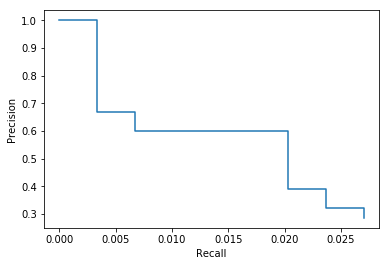

In [44]:
plt.plot(recalls[:-1], precisions[:-1])
plt.xlabel("Recall")
plt.ylabel("Precision")
# plt.xlim(0,1)
# plt.ylim(0,1)
plt.show()